In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [1]:
import keras 
import numpy as np
import librosa as lb
import sys
import os
# import pandas as pd
from keras.utils.training_utils import multi_gpu_model
from keras.utils import to_categorical,Sequence
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model,to_categorical
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
# from iter_window import window 
import speechpy as sp
# import statistics
from keras import backend as K
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.
/media/hinton/work2.7/local/lib/python2.7/site-packages/librosa/__init__.py:40: DeprecationWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  DeprecationWarning)


In [3]:
filename = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/protocol/CM_protocol/cm_train.trn'

# open the file for reading
filehandle = open(filename, 'r')
train_protocol = []
while True:
    # read a single line
    line = (filehandle.readline())
    train_protocol.append(line)
    if not line:
        break

# close the pointer to that file
filehandle.close()

In [4]:
train_protocol1 = []
for i in train_protocol:
    i = i.replace('\n','')
    train_protocol1.append(i)

train_protocol = train_protocol1

train_pd = []
train_label = []
for i in train_protocol:
    j = i.split(' ')[1:2]
    train_pd.append(j)
    train_label.append(i.split(' ')[3:4])
    
train_pd1 = []
for i in train_pd:
    train_pd1.append(str(i)[2:-2])
train_pd = train_pd1
#import names of files in dataset
path = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'
files = []
missing=[]
print(path)
for r, d, f in os.walk(path):
    for file in f:
        if '.wav' in file  :        
            files.append(os.path.join(r, file))
        else:
            missing.append(file)

#get train set
file_name=[]
for i in files:
    i = i.split('/')[-1].replace('.wav','')
    file_name.append(i)

file_set = set()
train_pd_set = set()

file_set = set(file_name)
train_pd_set = set(train_pd)

train_set = file_set & train_pd_set


/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/


## This code below ensures that train samples and train_labels are in the same order.

In [5]:
train_label = []
label_set = []
for k in train_set:
    for i in train_protocol1:
        j = str(i.split(' ')[1:2])[2:-2]
        if j==k:
            label_set.append(j)
            train_label.append(i.split(' ')[3])
            
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy",train_label)

In [6]:
#To save audio data of trainset
train_audio= []
for count, i in enumerate(train_set):
#     print(i)
    j = i.split('_')[0]
    train_audio.append(lb.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'+j+'/'+i+'.wav'))
    if count%1000==0 and count==1000:
        print('saving')
        np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/train"+str(count)+".npy",train_audio[0:count])
    elif count%1000==0 and count >= 1000:
        print('saving')
        np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/train"+str(count)+".npy",train_audio[count-1000:count])

saving
saving
saving
saving
saving


KeyboardInterrupt: 

In [ ]:
#To save audio data of trainset
from os import path
train_audio= []
missing_audio = []
for count, i in enumerate(train_set):
#     print(i)
    j = i.split('_')[0]
    if path.exists('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'+j+'/'+i+'.wav'):
        train_audio.append(i)
    else:
        missing_audio.append(i)

train_set_list = list(train_set)


# load npy files of the audio files

In [29]:
train = []
path = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof'
print(path)
for r, d, f in os.walk(path):
    for file in f:
        if '.npy' in file and 'train' in file and '_' not in file:        
            train.append(np.load(os.path.join(r, file), allow_pickle = True))

/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof


In [30]:
train_format = []
for i in range(len(train)):
    for j in train[i]:
        train_format.append(j[0]) 

In [31]:
train_format= np.array(train_format)

In [32]:
train_format[1]

array([0.00518005, 0.00855558, 0.00872142, ..., 0.0166531 , 0.01941423,
       0.01267171], dtype=float32)

# trim the audio file to the mean length of all the files

In [33]:
audio_shape=np.empty(16000)
for count,i in enumerate(train_format):
    audio_shape[count] = len(i)

In [34]:
mean = int(audio_shape.mean())
print(mean)

75673


In [35]:
trimmed_audio =pad_sequences(train_format,maxlen=mean,dtype='float32')

In [36]:
trimmed_audio.shape

(16000, 75673)

In [37]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/trimmed_audio.npy",trimmed_audio,allow_pickle = True)

# MFCC of the trimmed files

In [59]:
def mfcc(signal,sample_rate,num_ceps):
    pre_emphasis = 0.97
    frame_size = 0.025
    frame_stride = 0.01
    nfilt = 20
    NFFT = 512
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    frames *= numpy.hamming(frame_length)
    print(frames.shape,numpy.fft.rfft(frames, NFFT).shape)
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
    
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    mfcc = dct(filter_banks, type=2, axis=1,n=num_ceps, norm='ortho') # Keep 2-13
    return mfcc

In [33]:
60*471

28260

In [36]:
delta = []
delta2 = []
value = []
mfcc_feat_train = np.empty((16000,28260))
shape = []
mean_value = []

for count,f in enumerate(trimmed_audio):
    delta=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30)))
    delta2=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30), order=2))
    value = np.concatenate([delta,delta2], axis=1)
#     print(value.shape,delta.shape,delta2.shape)
#     shape = np.append(shape,(value.shape[0]))
    mean_value = sp.processing.cmvnw(value).reshape(1,-1)
#     padded_value =pad_sequences(mean_value,maxlen=74340,dtype='float32')
    mfcc_feat_train[count] = mean_value

    if count%100==0:
        print(count)

    

NameError: name 'trimmed_audio' is not defined

In [35]:
mfcc_feat_train.shape

(16000, 28260)

In [36]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/mfcc_train_padded.npy",mfcc_feat_train,allow_pickle = True)

# loading trim audio padded mfcc features for chunking and windowing to feed it into the DNN to get the BNF

In [2]:
data_train = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/mfcc_train_padded.npy",mmap_mode='r')

In [3]:
data_train[15890]

memmap([ 8.51031303,  8.51031303,  8.51031303, ..., -0.2501207 ,
        -0.2501207 , -0.2501207 ])

In [4]:
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = to_categorical(train_labels1[:16000])

In [5]:
len(train_labels)

16000

In [6]:
train_labels[1]

array([1., 0.], dtype=float32)

In [7]:
window_train = []
for i in batch_x:
    window_train.append(np.array(list(window(i,7,7))).ravel())

NameError: name 'batch_x' is not defined

In [8]:
window_train[1].shape

IndexError: list index out of range

In [9]:
def window( iterable, left, right, padding=0.0, step=1 ):
   
    from itertools import islice, repeat, chain
    from collections import deque

    n = left + right + 1

    iterator = chain(iterable,repeat(padding,right)) 
    
    elements = deque( repeat(padding,left), n )
    elements.extend( islice( iterator, right - step + 1 ) )

    while True: 
        for i in range(step):
            elements.append( next(iterator) ) 
        yield tuple( elements ) 


In [10]:
data_train.shape

(16000, 28260)

In [11]:
class chunking_windowing(Sequence):
    def __init__(self, data_train, train_labels, batch_size):
        self.data_train = data_train
        self.train_labels = train_labels
        self.batch_size = batch_size
        self.n = 0
        self.max = self.__len__()
        self.window_train = []
    def __len__(self):
        return np.ceil(len(self.data_train) / float(self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.data_train[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.train_labels[idx * self.batch_size:(idx + 1) * self.batch_size]
#         print(batch_x[1],idx)
        self.window_train = []
        for i in batch_x:
            self.window_train.append(np.array(list(window(np.array(i),7,7))).ravel())
#         print(len(self.window_train),len(batch_y))
        return np.array(self.window_train), np.array(batch_y)
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [12]:
training_batch_generator = chunking_windowing(data_train,train_labels, 64)

In [13]:
#define neural network

tri1=[]
model = Sequential()


model.add(Dense(256, activation='sigmoid', input_shape = (423900,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(64, activation='linear'))
model.add(Dense(2, activation='softmax'))
parallel_model = multi_gpu_model(model, gpus=2)
model.summary()
parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
layeroutputs = []
# for i in pad_window:
# model.fit(data_train, to_categorical(train_labels), epochs = 1,batch_size = 64)#, callbacks = callbacks_list, validation_data=(x_validation,y_validation))
parallel_model.fit_generator(generator=training_batch_generator,
                                          epochs=1,
                                          use_multiprocessing=True,
                                          workers=16,
                                          max_queue_size=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               108518656 
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              257000    
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 110,841,850
Trainable params: 110,841,850
Non-trainable params: 0
______________________________________________________________

In [14]:
get_5th_layer_output = K.function([model.layers[0].input],
                                 [model.layers[4].output])


In [54]:
tri,_=training_batch_generator.__getitem__(220)
print(tri[60][423])
# print(tri.shape,np.array(get_5th_layer_output([tri])[0]).shape)

-1.509903313490213e-14


In [15]:
# get_5th_layer_output([tri])[0]

output = np.empty((16000,64))
for i in range(250):
    tri,_=training_batch_generator.__getitem__(i)
    output[i*64:(i+1)*64] = get_5th_layer_output([tri])[0]



In [16]:
output[15991]

array([ 3.5197165 , -2.76450992,  1.3884964 ,  2.37760687,  1.17881203,
        1.60164881,  2.52368355,  2.01862526, -2.71429515,  2.46192074,
        1.94503689, -0.39924845,  1.63396573, -0.07062347, -1.49610174,
       -1.49422085,  1.50074971, -2.60775685, -1.55307364, -4.01265144,
        0.29723153, -0.82013243, -1.59997964, -0.34139746, -2.29955363,
        1.63179624,  2.62968469, -1.75878644,  3.08541417, -0.91737175,
       -1.69511545,  2.48976493, -2.37863898,  2.15475583, -0.84585363,
        0.89915287, -1.83453691, -1.35846162,  2.70305538, -0.45631886,
       -2.26960707, -0.40953058, -2.54984331,  2.96469831,  2.29533386,
        2.31720424,  1.93833578, -1.86551929,  0.90622699, -3.58797836,
        1.74561203, -1.83362579,  2.13164663, -0.75673485, -1.48672128,
        1.51459324, -1.2498765 ,  2.07877135, -0.34444395, -1.45566344,
        1.60406494,  1.36162007, -2.11379671,  2.28095794])

In [17]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF_try.npy",output)

In [4]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.utils import shuffle
import numpy as np

# Load Dataset and Labels
## 1 : Human and 0 : spoof

In [19]:
data_embedding=np.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF_try.npy')
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = train_labels1[0:16000]

In [20]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 12326, 1: 3674}

In [21]:
j , k = 0,0
# human_samples = np.empty((3674,17880)) # wrong array size as BNF is of size 3674,64
human_samples = np.empty((3674,64))# corrected
human_labels= []
# spoof_samples = np.empty((12326,17880))
spoof_samples = np.empty((12326,64))
spoof_labels = []
for count,i in enumerate(train_labels):
    if i ==1:
#         human_samples=np.append(human_samples,data_embedding[count])# Do not append insert the data at that position
        human_samples[j]=data_embedding[count]
        human_labels.append(train_labels[count])
        j = j+1
    elif i ==0:
#         spoof_samples=np.append(spoof_samples,data_embedding[count])
        spoof_samples[k] = data_embedding[count]
        spoof_labels.append(train_labels[count])
        k = k+1
        
print(len(human_labels))
print(len(spoof_labels))
print((human_samples[3673]))
        

3674
12326
[ 3.51967454 -2.76516294  1.38990271  2.37884879  1.17913902  1.60296726
  2.52430129  2.01912546 -2.71387196  2.46336937  1.94548345 -0.39876378
  1.63354659 -0.07063784 -1.49617505 -1.49387836  1.50096667 -2.6088469
 -1.55358505 -4.01324129  0.29700789 -0.82099789 -1.60070658 -0.34109309
 -2.29979777  1.63179326  2.62989593 -1.75923729  3.08628273 -0.91757399
 -1.69509816  2.49041057 -2.37842107  2.1543355  -0.84551716  0.89973867
 -1.83450615 -1.35896111  2.70324659 -0.45702261 -2.26928854 -0.40861395
 -2.5493474   2.96498704  2.29540992  2.31759667  1.93799388 -1.86568522
  0.90620327 -3.5875175   1.74515247 -1.83407068  2.13221002 -0.7572515
 -1.48629045  1.51438594 -1.24952602  2.07843208 -0.34460622 -1.45513034
  1.60312402  1.36099279 -2.11454487  2.2812016 ]


In [22]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_samples.npy",human_samples,allow_pickle=True)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_samples.npy",spoof_samples,allow_pickle=True)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_labels.npy",human_labels)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_labels.npy",spoof_labels)

# Fit GMM for human samples

In [23]:
human_samples = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_samples.npy")
human_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_labels.npy")
spoof_samples = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_samples.npy")
spoof_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_labels.npy")

In [24]:
gmm = GMM(n_components=512).fit(human_samples)

# Fit GMM for spoof samples

In [25]:
gmm_spoof = GMM(n_components=512).fit(spoof_samples)

# Calculate predicted values for the train data

In [9]:
data_embedding=np.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF.npy')
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

In [10]:
train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = train_labels1[0:16000]


In [26]:
llr_natural = gmm.score_samples(data_embedding)
llr_spoof = gmm_spoof.score_samples(data_embedding)

In [27]:
llr_natural

array([380.47194788, 380.47194788, 380.04717056, ..., 377.32148152,
       212.55868929, 379.07312465])

In [28]:
llr_spoof

array([380.25192495, 380.25192495, 379.9113428 , ..., 377.61243855,
       373.8648056 , 379.06700283])

In [29]:
llr_score = llr_natural - llr_spoof     

In [30]:
y_predicted = np.empty(16000)
for i in range(len(llr_score)):
    y_predicted[i] = int(llr_score[i]>0)

In [31]:
fpr, tpr, threshold = roc_curve(train_labels, y_predicted)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

In [32]:
eer

0.4286674999374808

In [33]:
auc = roc_auc_score(train_labels,y_predicted)

In [34]:
auc

0.61866799347185

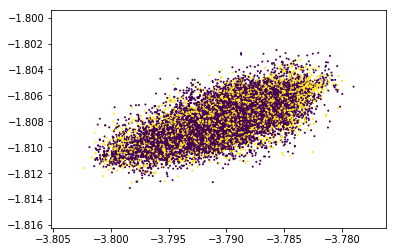

In [19]:
plt.scatter(data_embedding[:,0], data_embedding[:,1], c=y_predicted, s=1, cmap='viridis');

# ROC where context is included while feeding the data into the DNN:

In [21]:
ns_probs = [0 for _ in range(len(train_labels))]

In [22]:
ns_auc = roc_auc_score(train_labels, ns_probs)

In [23]:
ns_fpr, ns_tpr, _ = roc_curve(train_labels, ns_probs)

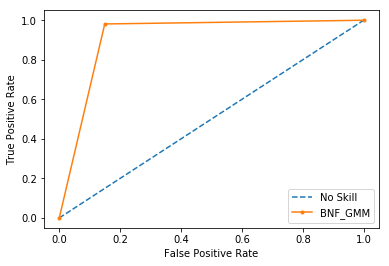

In [26]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='BNF_GMM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [2]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(train_labels, y_predicted) 
print 'Confusion Matrix :'
print(results) 
print 'Accuracy Score :',accuracy_score(train_labels, y_predicted) 
print 'Report : '
print classification_report(train_labels, y_predicted) 

NameError: name 'train_labels' is not defined

# Spectrogram Analysis
## Correct Classes [genuine VS spoofed]
### seperating the correctly classified from the missclassified samples
#### Cases:
#### if sample is human and same in y_predicted and train_labels
#### if sample is Spoofed and same in y_predicted and train_labels
#### if sample is human and different in y_predicted and train_labels
#### if sample is spoofed and different in y_predicted and train_labels

In [2]:
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")
trimmed_audio = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/trimmed_audio.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = train_labels1[0:16000]

In [20]:
correct_human = []
correct_spoofed = []
miss_human = []
miss_spoofed = []
for count,i in enumerate(train_labels):
    if i == y_predicted[count]:
        if i == 1:
            correct_human.append(count)
        elif i == 0:
            correct_spoofed.append(count)
    elif i != y_predicted[count]:
        if i == 1:
            miss_human.append(count)
        elif i == 0:
            miss_spoofed.append(count)
        
        
        

In [21]:
len(correct_human),len(correct_spoofed),len(miss_human),len(miss_spoofed)

(3591, 10480, 83, 1846)

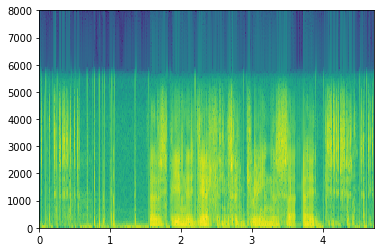

In [83]:
plt.specgram(trimmed_audio[correct_spoofed[20]],Fs=16000);

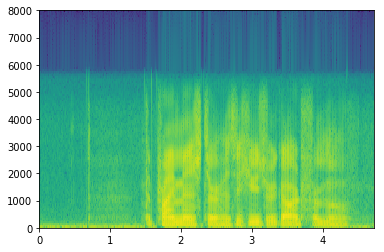

In [80]:
plt.specgram(trimmed_audio[miss_spoofed[14]],Fs=16000);

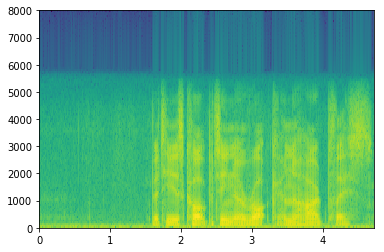

In [79]:
plt.specgram(trimmed_audio[correct_human[14]],Fs=16000);

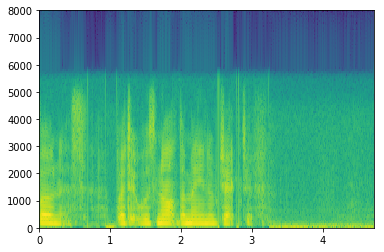

In [75]:
plt.specgram(trimmed_audio[miss_human[14]],Fs=16000);

In [78]:
from IPython.display import Audio

In [91]:
Audio(trimmed_audio[correct_human[30]], rate=16000)

In [96]:
Audio(trimmed_audio[correct_spoofed[50]], rate=16000)

In [100]:
Audio(trimmed_audio[miss_human[50]], rate=16000)

In [101]:
Audio(trimmed_audio[miss_spoofed[50]], rate=16000)

# Trying Continuous wavelet transform in this model

In [2]:
import numpy as np
import pywt
import librosa as lb
import speechpy as sp
from keras.utils import plot_model,to_categorical

In [7]:
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")
trimmed_audio = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/trimmed_audio.npy")

In [3]:
trimmed_audio.shape

(16000, 75673)

In [51]:
def cwt(x):
    scales = range(1,512)
    waveletname = 'morl'
    x_cwt = np.ndarray(shape=(127,127))
    signal = x
    coeff, freq = pywt.cwt(signal, np.asarray(scales), waveletname, 1)
    coeff_ = coeff[:,:127]
    
    return coeff_

In [54]:
waveletname = 'morl'
scales = range(1,512)
coeff, freq = pywt.cwt(trimmed_audio[1], np.asarray(scales), waveletname, 1)
coeff.shape

(511, 75673)

In [50]:
coeff.shape
coeff_ = coeff[:,:127]
coeff_.shape

(127, 127)

# This next code snippet is used to get cwt features from the trimmed audio

In [55]:
#already wrote a script to get cwt_train in cwt_train.py
# delta = []
# delta2 = []
# value = []
# cwt_feat_train = np.empty((16000,32258))
# shape = []
# mean_value = []

# for count,f in enumerate(trimmed_audio):
# #     print(f.shape)
    
#     delta=np.array(lb.feature.delta(cwt(f)))
    
#     delta2=np.array(lb.feature.delta(cwt(f), order=2))
#     value = np.concatenate([delta,delta2], axis=1)
# #     print(value.shape,delta.shape,delta2.shape)
# #     shape = np.append(shape,(value.shape[0]))
#     mean_value = sp.processing.cmvnw(value).reshape(1,-1)
# #     print(len(mean_value[0]))
# #     padded_value =pad_sequences(mean_value,maxlen=74340,dtype='float32')
#     cwt_feat_train[count] = mean_value

#     if count%100==0:
#         print(count)

# loading trim audio padded CWT features for chunking and windowing to feed it into the DNN to get the BNF

In [3]:
cwt_train = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/cwt_train.npy")

In [4]:
cwt_train.shape

(16000, 7620)

In [78]:
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = to_categorical(train_labels1[:16000])

In [6]:
def window( iterable, left, right, padding=0.0, step=1 ):
   
    from itertools import islice, repeat, chain
    from collections import deque

    n = left + right + 1

    iterator = chain(iterable,repeat(padding,right)) 
    
    elements = deque( repeat(padding,left), n )
    elements.extend( islice( iterator, right - step + 1 ) )

    while True: 
        for i in range(step):
            elements.append( next(iterator) ) 
        yield tuple( elements ) 


In [7]:
class chunking_windowing(Sequence):
    def __init__(self, data_train, train_labels, batch_size):
        self.data_train = data_train
        self.train_labels = train_labels
        self.batch_size = batch_size
        self.n = 0
        self.max = self.__len__()
        self.window_train = []
    def __len__(self):
        return np.ceil(len(self.data_train) / float(self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.data_train[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.train_labels[idx * self.batch_size:(idx + 1) * self.batch_size]
#         print(batch_x[1],idx)
        self.window_train = []
        for i in batch_x:
            self.window_train.append(np.array(list(window(np.array(i),7,7))).ravel())
#         print(len(self.window_train),len(batch_y))
        return np.array(self.window_train), np.array(batch_y)
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [8]:
training_batch_generator = chunking_windowing(cwt_train,train_labels, 64)

In [10]:
tri1=[]
model = Sequential()


model.add(Dense(512, activation='sigmoid', input_shape = (114300,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(64, activation='linear'))
model.add(Dense(2, activation='softmax'))
parallel_model = multi_gpu_model(model, gpus=2)
model.summary()
parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
layeroutputs = []
# for i in pad_window:
# model.fit(data_train, to_categorical(train_labels), epochs = 1,batch_size = 64)#, callbacks = callbacks_list, validation_data=(x_validation,y_validation))
parallel_model.fit_generator(generator=training_batch_generator,
                                          epochs=1,
                                          use_multiprocessing=True,
                                          workers=16,
                                          max_queue_size=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               58522112  
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              513000    
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                64064     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 61,101,306
Trainable params: 61,101,306
Non-trainable params: 0
________________________________________________________________

In [11]:
get_5th_layer_output = K.function([model.layers[0].input],
                                 [model.layers[4].output])


In [12]:
output = np.empty((16000,64))
for i in range(250):
    tri,_=training_batch_generator.__getitem__(i)
    output[i*64:(i+1)*64] = get_5th_layer_output([tri])[0]
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [13]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/CWT_BNF.npy",output)

# Load Dataset and Labels
## 1 : Human and 0 : spoof

In [2]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.utils import shuffle
import numpy as np

In [84]:
data_embedding=np.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/CWT_BNF.npy')
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = train_labels1[0:16000]

In [16]:
j , k = 0,0
# human_samples = np.empty((3674,17880)) # wrong array size as BNF is of size 3674,64
human_samples = np.empty((3674,64))# corrected
human_labels= []
# spoof_samples = np.empty((12326,17880))
spoof_samples = np.empty((12326,64))
spoof_labels = []
for count,i in enumerate(train_labels):
    if i ==1:
#         human_samples=np.append(human_samples,data_embedding[count])# Do not append insert the data at that position
        human_samples[j]=data_embedding[count]
        human_labels.append(train_labels[count])
        j = j+1
    elif i ==0:
#         spoof_samples=np.append(spoof_samples,data_embedding[count])
        spoof_samples[k] = data_embedding[count]
        spoof_labels.append(train_labels[count])
        k = k+1
        
print(len(human_labels))
print(len(spoof_labels))
print((human_samples[3673]))

3674
12326
[ 2.83706910e-03  2.41702765e-01 -1.75982136e-02  7.98080981e-01
  4.31967080e-01 -6.11934997e-03  1.54464930e-01 -3.79429638e-01
 -3.37917432e-02  3.05916250e-01 -2.86069363e-01 -1.40521646e-04
  3.36098075e-02 -1.20077608e-02  9.06394329e-04  4.16513458e-02
  1.55284390e-01  4.43145245e-01  7.38303512e-02 -5.53461015e-01
  8.59957486e-02 -2.24103853e-01  1.91327482e-01  9.56445709e-02
 -1.80474892e-01 -1.67463928e-01  1.35553211e-01  3.52380961e-01
 -4.97810185e-01  2.68353373e-02  6.63722353e-03 -9.51271206e-02
 -1.06910780e-01 -2.50253350e-01  2.87810296e-01 -3.56325477e-01
 -1.84223846e-01  3.19468975e-01  1.82661429e-01 -7.02259004e-01
 -1.57634184e-01  1.03193834e-01  2.09834501e-01  2.56182581e-01
  3.09817586e-02 -4.01352882e-01  2.25102067e-01 -5.07295310e-01
  5.27572989e-01  4.07925636e-01  2.37873960e-02  8.69684666e-02
 -2.66491566e-02 -9.87610444e-02 -3.16750556e-01 -2.02034608e-01
 -7.43395239e-02 -1.76584944e-01 -2.61218287e-03 -3.47538829e-01
 -2.31757700e-

In [17]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/cwt_human_samples.npy",human_samples,allow_pickle=True)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/cwt_spoof_samples.npy",spoof_samples,allow_pickle=True)

# Fit GMM for human samples

In [18]:
gmm = GMM(n_components=512).fit(human_samples)

# Fit GMM for spoof samples

In [19]:
gmm_spoof = GMM(n_components=512).fit(spoof_samples)

In [20]:
llr_natural = gmm.score_samples(data_embedding)
llr_spoof = gmm_spoof.score_samples(data_embedding)

In [21]:
llr_score = llr_natural - llr_spoof     

In [22]:
y_predicted = np.empty(16000)
for i in range(len(llr_score)):
    y_predicted[i] = int(llr_score[i]>0)

In [23]:
fpr, tpr, threshold = roc_curve(train_labels, y_predicted)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

In [24]:
eer

0.41009230738754865

In [25]:
auc = roc_auc_score(train_labels,y_predicted)

In [26]:
auc

0.6443205147829811

In [27]:
trimmed_audio[1].shape

NameError: name 'trimmed_audio' is not defined

In [22]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'morl', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im)
    plt.show()

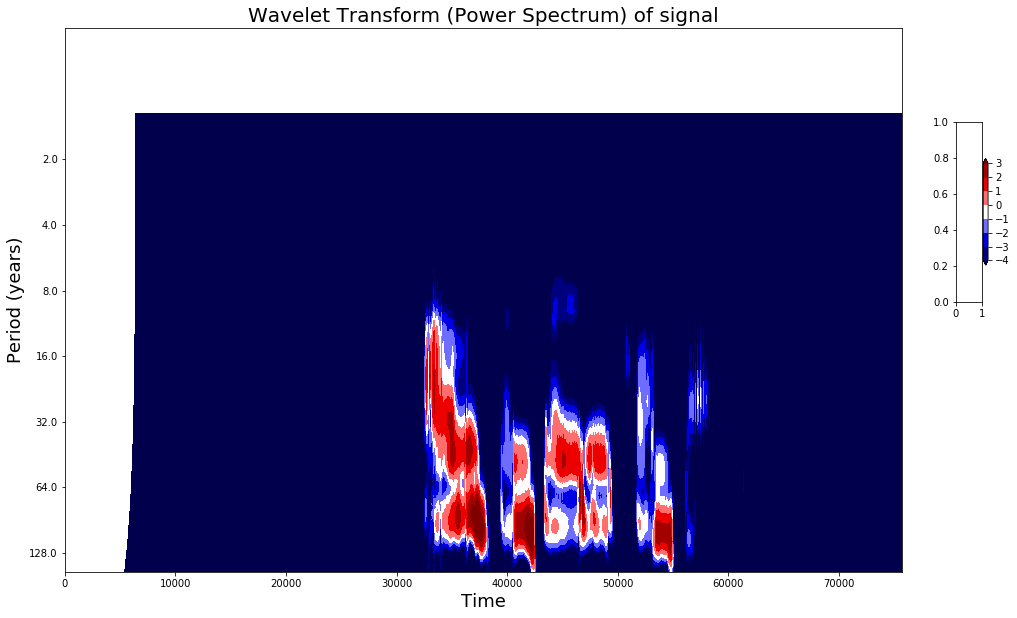

In [24]:
N = trimmed_audio[1].shape[0]
dt = 1
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,trimmed_audio[1],scales)

In [85]:
correct_human = []
correct_spoofed = []
miss_human = []
miss_spoofed = []
count = 0
for count,i in enumerate(train_labels):
    if i == y_predicted[count]:
        if i == 1:
            correct_human.append(count)
        elif i == 0:
            correct_spoofed.append(count)
    elif i != y_predicted[count]:
        if i == 1:
            miss_human.append(count)
        elif i == 0:
            miss_spoofed.append(count)
        

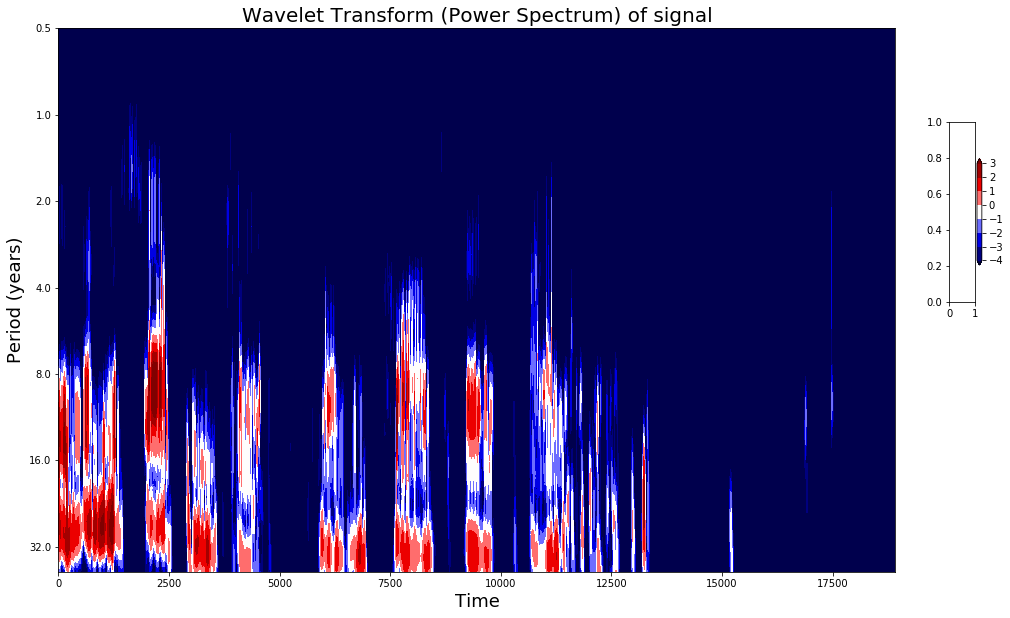

In [166]:
N = trimmed_audio[correct_spoofed[10]].shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,trimmed_audio[correct_spoofed[10]],scales)

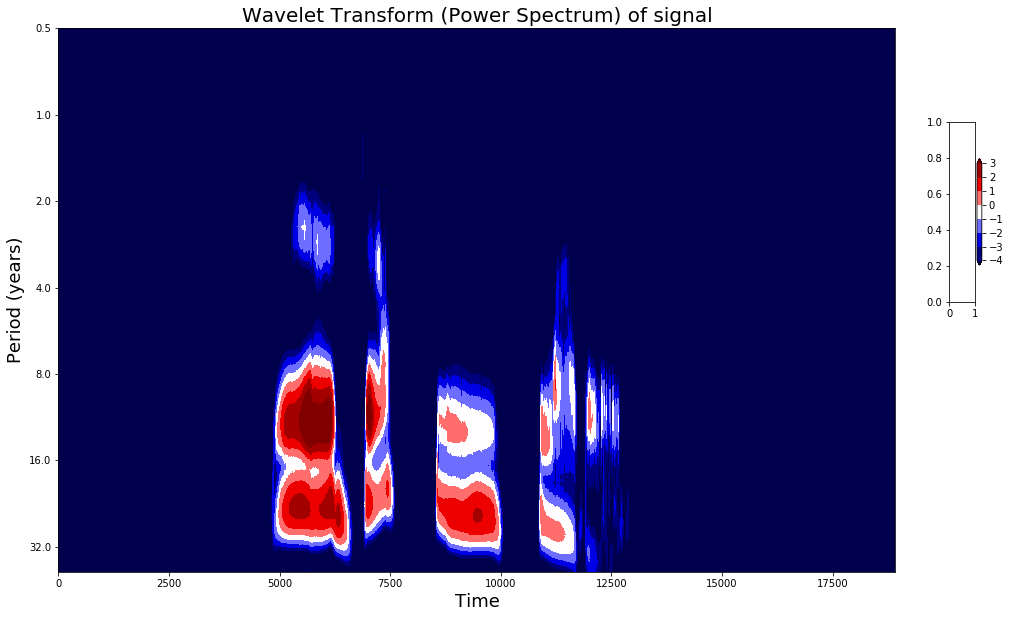

In [167]:
N = trimmed_audio[correct_human[34]].shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,trimmed_audio[correct_human[34]],scales)

In [9]:
audio1f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p318_212.gen_13.wav")

28336


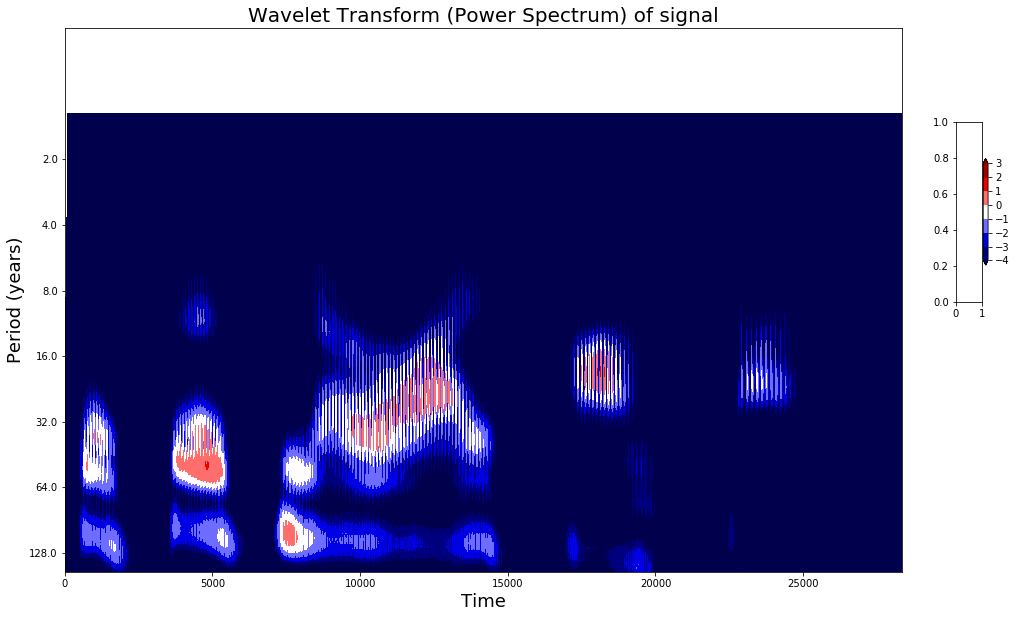

In [17]:
N = audio1f.shape[0]
print(N)
dt = 1
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio1f,scales)
# audio1

In [4]:
from IPython.display import Audio
Audio(audio1f,rate=16000)

NameError: name 'audio1f' is not defined

In [14]:
audio1o,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p318_212.orig.wav")

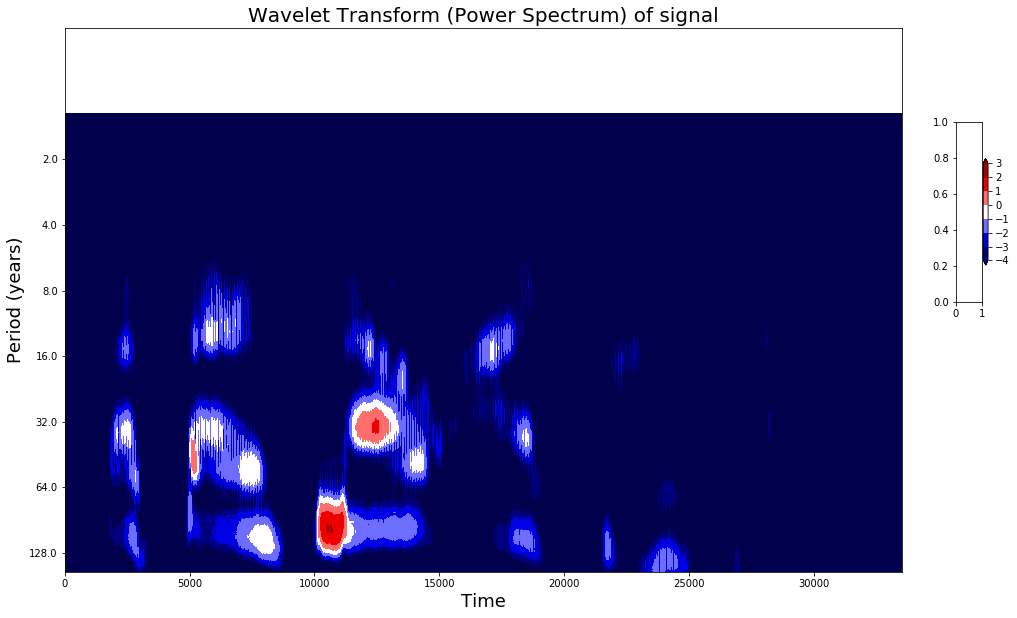

In [19]:
N = audio1o.shape[0]
dt = 1
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio1o,scales)

In [138]:
Audio(audio1o,rate=16000)

In [139]:
audio2f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p330_132.gen_18.wav")

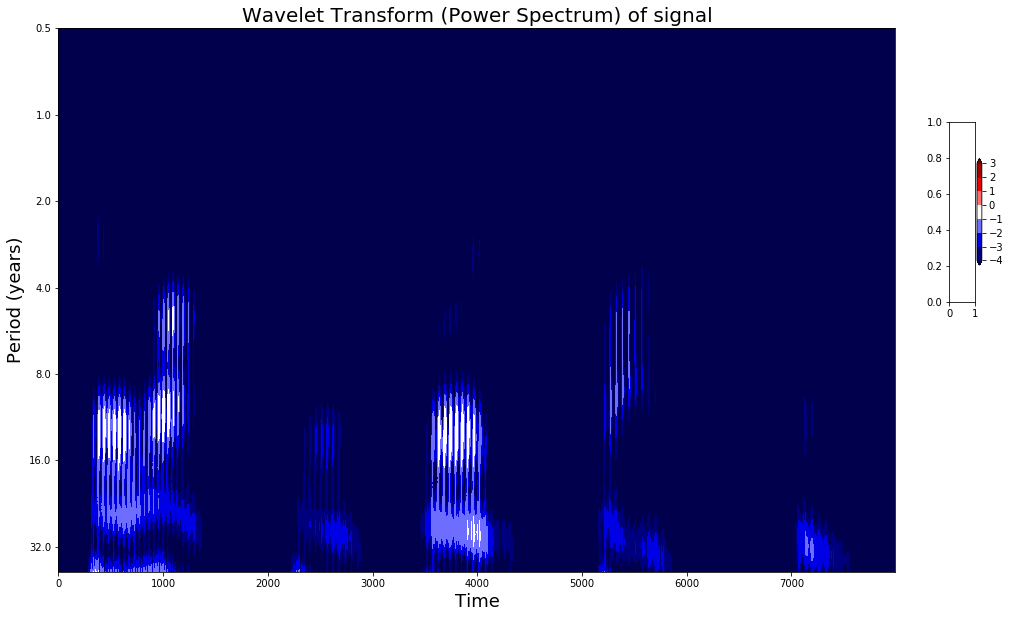

In [172]:
N = audio2f.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio2f,scales)

In [153]:
Audio(audio2f,rate=16000)

In [179]:
audio2o,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p330_132.orig.wav")

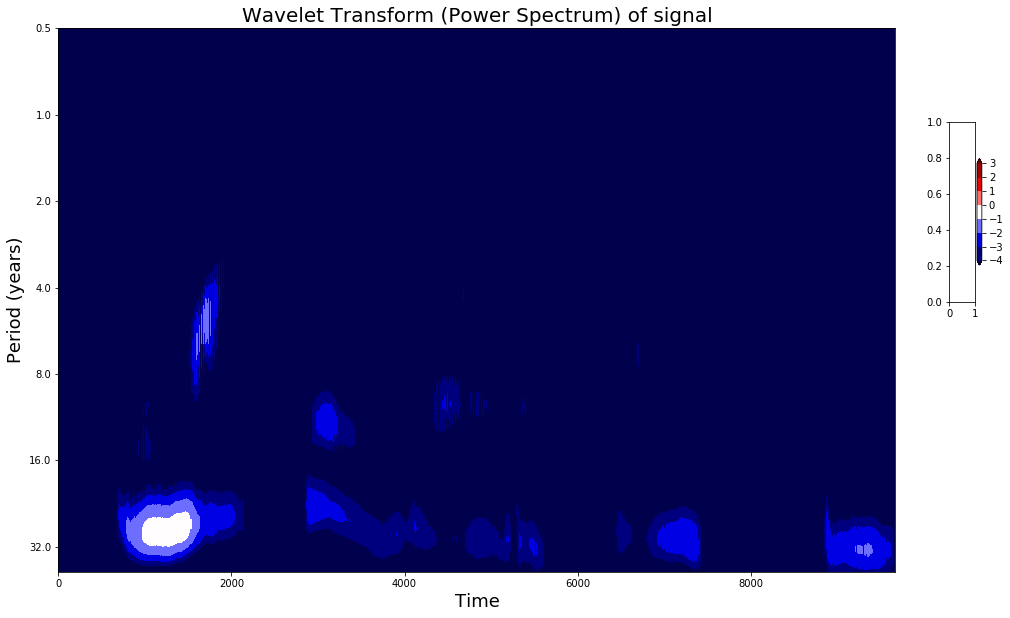

In [180]:
N = audio2o.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio2o,scales)

In [154]:
Audio(audio2o,rate=16000)

In [23]:
audio3f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p294_121.gen_0.wav")

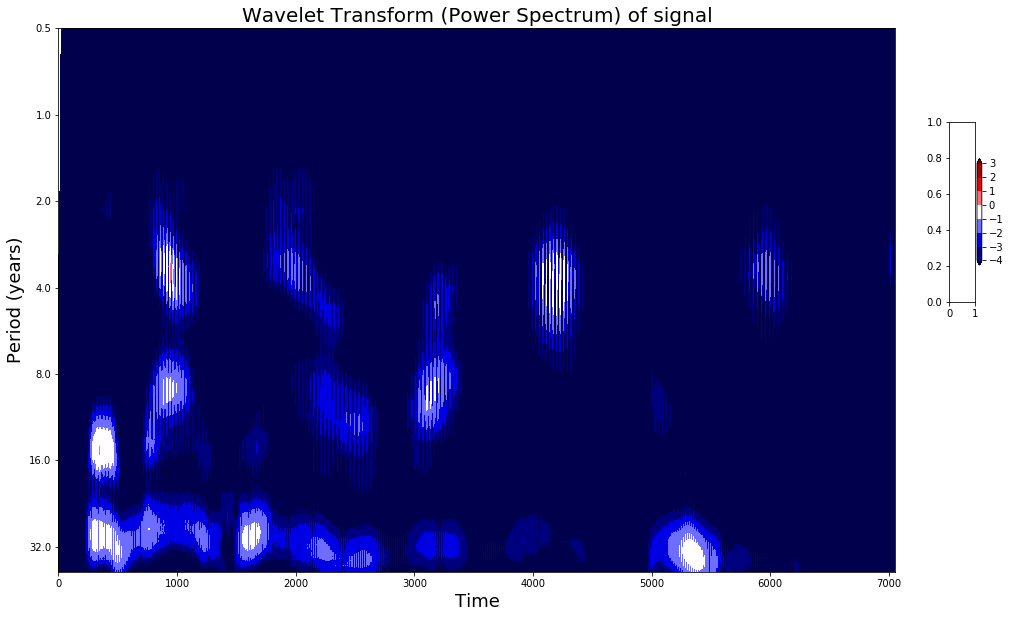

In [24]:
N = audio3f.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio3f,scales)

In [25]:
Audio(audio3f,rate=16000)

In [20]:
audio3o,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p294_121.orig.wav")

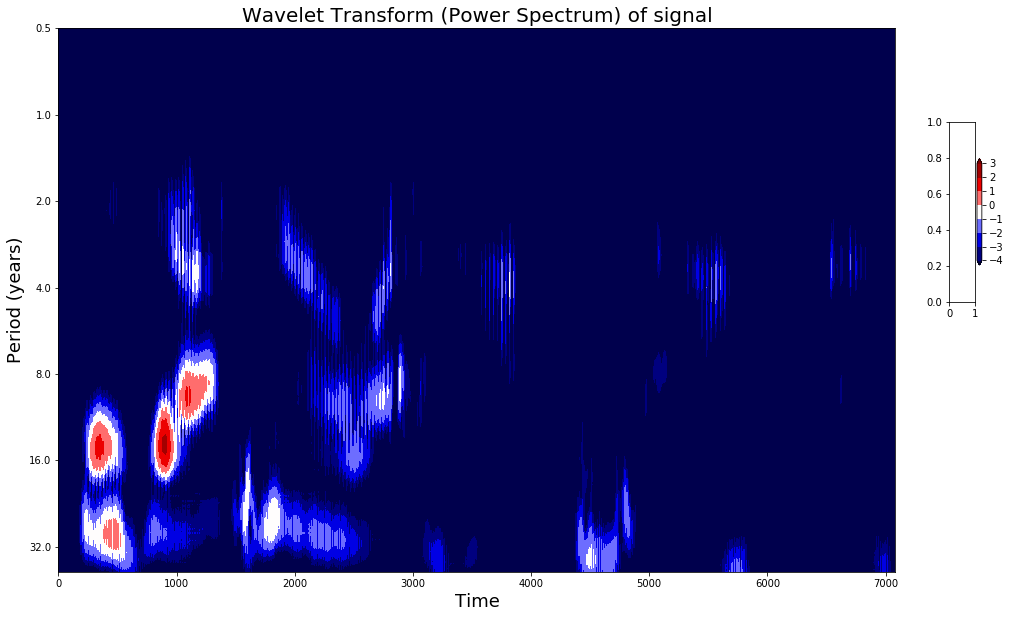

In [26]:
N = audio3o.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio3o,scales)

In [22]:
Audio(audio3o,rate=16000)

In [3]:
audio4f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p297_036.gen_1.wav")

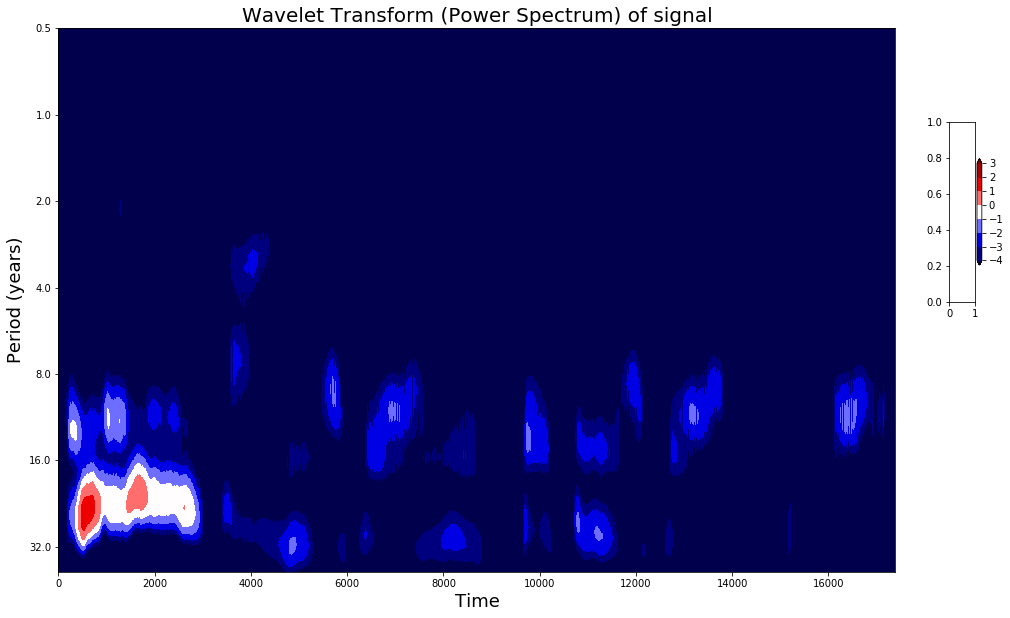

In [11]:
N = audio4f.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio4f,scales)

In [14]:
Audio(audio4f,rate=16000)

In [16]:
audio4o,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/voiceloop_samples/results/p297_036.orig.wav")

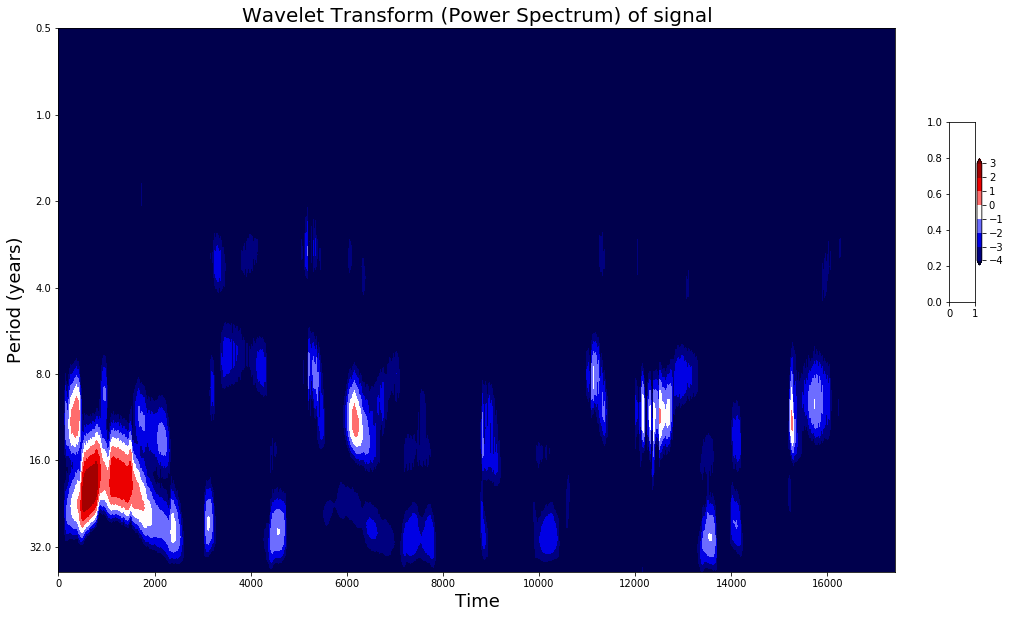

In [17]:
N = audio4o.shape[0]
dt = 0.25
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio4o,scales)

In [18]:
Audio(audio4o,rate=16000)

In [25]:
audio5f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/starganvc_fake_male_voice1.wav")

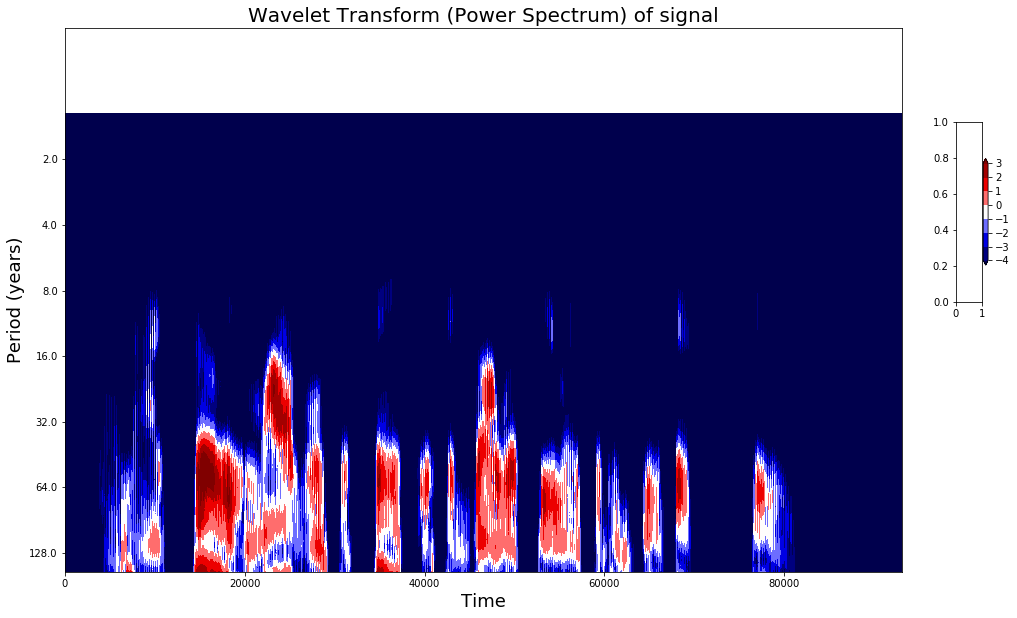

In [27]:
N = audio5f.shape[0]
dt = 1
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio5f,scales)

In [17]:
Audio(audio5f,rate=22050 )

In [29]:
audio5o,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/starganvc_original_male_voice1.wav")

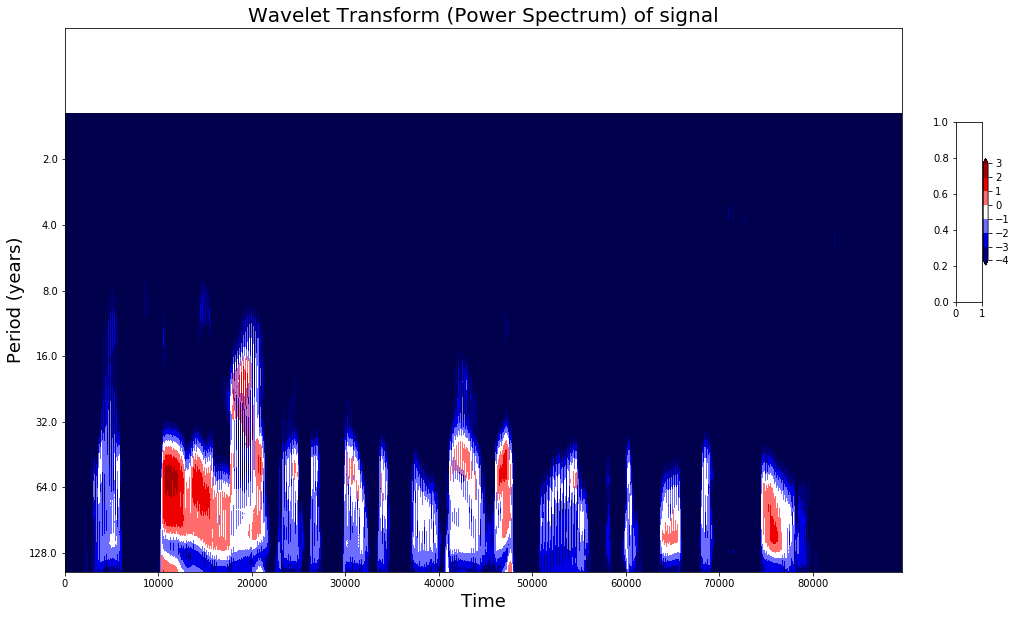

In [30]:
N = audio5o.shape[0]
dt = 1
time = np.arange(0, N) * dt
scales = np.arange(1, 128)
plot_wavelet(time,audio5o,scales)

In [18]:
Audio(audio5o,rate=22050 )

In [7]:
audio6f,_ = lb.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/spoof_detection_deep_features/sample_analysis/starganvc_fake_male_voice2.wav")

NoBackendError: 